In [19]:
#!/usr/bin/env python3

import sys
import pickle
import re
import os
import csv
import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

We need to change directory to wherever the input files are located.

In [3]:
os.chdir("/mnt/c//Users/Maya/Dropbox/PTE_results")

In [4]:
# Later, load in the results for analysis
with open('S6_full_all.p', 'rb') as f:
    all_ref = pickle.load(f)

In [5]:
print(all_ref['S6'].keys())

dict_keys(['d9', 'd6', 'i6', 'd3', 'i3', 'i9'])


The `all_ref` dictionary contains all information collected from sequenced, aggregated by protein background (here wtPTE, dubbed S6 for all fractions) and then by fraction / type of library. There is no filterin on this point, so `all_ref` includes all sequencing error, frameshifts, variants with extra point mutations etc.

Each key in the dictionary takes the format:

```
protein_mutation : {'total': integer_count, 
                    'dna_hgvs': {'dna_in_HGVS_format': count},
                    'dna': {'dna_in_tuple_format': count} # this is for each DNA mutation that generates that protein mutation
                   }
```
So, if we want to know all mutations in a certain position in a library, we need `all_ref['S6']['d3](protein_tuple)['dna'].items()` or some such.

In [34]:
def classify_dna(dna_error):
    if dna_error is None:  # empty or broken reads
        return 'b'
    elif dna_error == ():
        return 'wt'
    elif len(dna_error) > 1:
        # expect substitutions
        if dna_error[-1][1] == 'f':  # frameshifts are always the last mutation
            return 'f'
        else:
            for k in range(len(dna_error)):
                if dna_error[k][1] == 'i':
                    return 'si'
                elif dna_error[k][1] == 'd':
                    return 'sd'
            return 's'
    elif len(dna_error) == 1:
        if dna_error[0][1] == 'f':
            return 'f'
        elif dna_error[0][1] == 'd':
            return 'd' + dna_error[0][2]  # length of deletion
        elif dna_error[0][1] == 'i':
            return 'i' + str(len(dna_error[0][2]))
        elif dna_error[0][1] == 's':
            return 's'
    else:
        return 'b'


def get_dna_composition(all_references, cutoff=10):
    """
    Classify all detected mutations by what kind they are: substitution, deletion, insertion (including length), frameshift, or other.
    Collect the results in a dataframe, for both proteins and DNA mutations.
    Only mutations
    """

    dna_count = {}
    dna_reads = {}
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            # print('Analysing background {0} and fraction {1}. Unusal mutations: '.format(background, fraction))
            distinct_mutations = 0
            total_count = 0
            dna_count[background + '.' + fraction] = {'s': 0, 'd3': 0, 'd6': 0, 'd9': 0, 'i3': 0, 'i6': 0, 'i9': 0, 'f': 0,
                                                'b': 0, 'other': 0, 'sd': 0, 'si': 0}
            dna_reads[background + '.' + fraction] = {'s': 0, 'd3': 0, 'd6': 0, 'd9': 0, 'i3': 0, 'i6': 0, 'i9': 0, 'f': 0,
                                                'b': 0, 'other': 0, 'sd': 0, 'si': 0}
            for mutation in all_references[background][fraction].keys():
                mut_total = all_references[background][fraction][mutation]['total']
                if mut_total >= cutoff:
                    # find all DNA entries with high enough counts
                    for dna_error, c in all_references[background][fraction][mutation]['dna'].items():
                        # dna_error = max(all_references[background][fraction][mutation]['dna'],
                        #  key=lambda key: all_references[background][fraction][mutation]['dna'][key])
                        if c >= cutoff:
                            try:
                                dna_type = classify_dna(dna_error)
                                if dna_type == 'wt':
                                    continue
                                elif dna_type == 'b':
                                    print(dna_type, dna_error, mut_total)
                                dna_count[background + '.' + fraction][dna_type] += 1
                                dna_reads[background + '.' + fraction][dna_type] += c
                                distinct_mutations += 1
                                total_count += c
                            except KeyError:
                                #print(dna_type, dna_error, mut_total)
                                dna_count[background + '.' + fraction]['other'] += 1
                                dna_reads[background + '.' + fraction]['other'] += c
            # print('In background {0} and fraction {1} found {2} distinct mutations with total read count {3}'.format(
            #     background, fraction, distinct_mutations, total_count
            # ))

    return dna_count, dna_reads


def classify_protein(mutation):
    """
    Detect whether a protein mutation is an insertion/deletion/substituion and if more than 1, (non)consecutive
    :param mutation:
    :return:
    """
    if mutation is None:  # came from empty or broken reads
        return 'b'
    else:
        m = []
        for pos in range(len(mutation)):
            t = mutation[pos][1]
            if t != 'i':
                m.append(t)
            else:
                m.append(t + str(len(mutation[pos][2])))
        # need to distinguish between consecutive mutations and likely sequencing errors
        if 'f' in m:
            return 'f'
        elif len(m) == 1:
            return ''.join(m)
        elif len(m) >= 1:
            c = is_mutation_consecutive(mutation) + '-' + ''.join(m)
            return c
        
def is_mutation_consecutive(mutation):
    """
    If only consecutve amino acids are affected, return 'c', else return 'nc'
    :param mutation:
    :return:
    """
    for pos in range(1, len(mutation)):
        if mutation[pos][0] != (mutation[pos - 1][0] + 1) :
            return 'nc'
    return 'c'

def dna_protein_correspondence(dna_type):
    
    dna_to_prot_type = {'d3':['d', 'c-sd'], 'd6':['c-dd', 'c-sdd'], 'd9':['c-ddd', 'c-sddd'],
                'i3':['i1','c-si1'], 'i6': ['i2','c-si2'], 'i9':['i3','c-si3']}
    
    try:
        return dna_to_prot_type[dna_type]
    except KeyError:
        []

        
def get_protein_composition(all_references, cutoff=10):
    protein_count = {}
    protein_reads = {}
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            # print('Analysing protein composition in background {0} and fraction {1}. Unusal mutations: '.format(background, fraction))
            distinct_mutations = 0
            total_count = 0
            protein_count[background + '.' + fraction] = {'s': 0, 'd': 0, 'c-dd': 0, 'c-ddd': 0, 'i1': 0, 'i2': 0,
                            'i3': 0, 'c-ss': 0, 'c-sd': 0, 'c-sdd': 0, 'c-sddd': 0, 'c-si1': 0, 'c-si2': 0, 'c-si3': 0,
                            'f': 0, 'other': 0, 'b': 0}
            protein_reads[background + '.' + fraction] = {'s': 0, 'd': 0, 'c-dd': 0, 'c-ddd': 0, 'i1': 0, 'i2': 0,
                            'i3': 0, 'c-ss': 0, 'c-sd': 0, 'c-sdd': 0, 'c-sddd': 0, 'c-si1': 0, 'c-si2': 0, 'c-si3': 0,
                            'f': 0, 'other': 0, 'b': 0}
            for mutation in all_references[background][fraction].keys():
                mut_total = all_references[background][fraction][mutation]['total']
                if mut_total >= cutoff:
                    # find all DNA entries with high enough counts
                    try:
                        prot_type = classify_protein(mutation)
                        protein_count[background + '.' + fraction][prot_type] += 1
                        protein_reads[background + '.' + fraction][prot_type] += mut_total
                        distinct_mutations += 1
                        total_count += mut_total
                    except KeyError:
                        # print(prot_type, mutation, mut_total)
                        protein_count[background + '.' + fraction]['other'] += 1
                        protein_reads[background + '.' + fraction]['other'] += mut_total
            # print('In background {0} and fraction {1} found {2} distinct mutations with total read count {3}'.format(
            #     background, fraction, distinct_mutations, total_count
            # ))

    return protein_count, protein_reads

### Overall composition of libraries
Tables

Now start with statistics
1. Generate CSV files that give overall composition of libraries on protein and DNA level

In [7]:
dna_count, dna_reads = get_dna_composition(all_ref, 1)
protein_count, protein_reads = get_protein_composition(all_ref, 1)

b None 16097
b None 17718
b None 97637
b None 14958
b None 72875
b None 90659


In [8]:
row_index_dna = ['d3', 'd6', 'd9', 'i3', 'i6', 'i9', 's', 'sd', 'si', 'other']
fractions = ['S6.d3', 'S6.d6', 'S6.d9', 'S6.i3', 'S6.i6', 'S6.i9']

df_dna_count = pd.DataFrame(dna_count, index=row_index_dna, columns=fractions)
df_dna_reads = pd.DataFrame(dna_reads, index=row_index_dna, columns=fractions)

df_dna_count

,S6.d3,S6.d6,S6.d9,S6.i3,S6.i6,S6.i9
d3,643,224,278,208,211,266
d6,28,694,53,126,177,171
d9,5,241,617,80,66,76
i3,2,10,0,20880,310,154
i6,2,5,5,4,107175,932
i9,0,8,1,18,18,103724
s,6140,7303,6909,18296,18923,14528
sd,2333,1901,1785,1038,1878,2164
si,4,474,7,4712,6600,5586
other,35,167,252,332,378,422


In [9]:
row_index_protein = [ 'd', 'c-sd', 'c-dd', 'c-sdd', 'c-ddd','c-sddd', 'i1','c-si1', 'i2','c-si2', 'i3','c-si3','s', 'c-ss','f', 'other']
df_protein_reads = pd.DataFrame(protein_reads, index=row_index_protein, columns=fractions)
df_protein_count = pd.DataFrame(protein_count, index=row_index_protein, columns=fractions)

df_protein_count

,S6.d3,S6.d6,S6.d9,S6.i3,S6.i6,S6.i9
d,302,146,188,143,151,183
c-sd,267,73,77,148,157,173
c-dd,19,322,42,82,135,128
c-sdd,11,292,19,109,131,136
c-ddd,5,145,307,73,53,65
c-sddd,1,78,220,56,93,72
i1,2,21,0,4890,297,129
c-si1,0,72,0,3604,302,115
i2,3,4,4,4,37279,681
c-si2,0,2,1,0,21686,450


### Figure 3A (after normalization for baseline from codon ambiguity).

Generate data for a histogram of tranposon insertion sites: best used for -3 bp library, it shows how many times a mutation is detected at each DNA position. Spikes corresponds to sites close to tranposon preferred insertion sequence (GC rich). This data still needs to be normalized for whether a position can be detected due to codon ambiguity.

InDel placement is inheretnly ambiguous. For example, if the original sequence is GCT TCA and we observe GC- --A, it could just as well come from G-- -CA. Any algorithm will arbitrarily favour one over another. Here, if the true deletions were one of each, the use of Needleman-Wunsch algorith to place deletions will favour placing InDels earlier in the sequence. Hence, G-- -CA will be reported twice and GC- --A zero times. When we are considering the transposon preference, the best we can do is to split the observed count across all positions where it could have come from, equally.



In [10]:
def find_transposon_histogram(all_references, background, baseline='baseline', transposon='d3'):
    """
    Find all mutation of a certain type and count where they are in DNA
    :return: dict
    """
    hist = defaultdict(int)

    for prot_mutation in all_references[background][baseline]:
        if prot_mutation is None:
            continue
        elif len(prot_mutation) <= 2:
            for dna_mutation, count in all_references[background][baseline][prot_mutation]['dna'].items():
                if classify_dna(dna_mutation) == transposon:
                    hist[int(dna_mutation[0][0])] += count

    return hist

histogram = find_transposon_histogram(all_ref, 'S6', baseline='d3', transposon='d3')

df_hist = pd.DataFrame(histogram, index=['raw_insertions'], columns=list(range(1000)))
df_hist = df_hist.fillna(0).transpose()

### Figure 3B: Number of observed deletions per position

In [11]:
def insertion_frequencies(all_references):
    """
    Generate data for number of different insertions per position.
    :param all_references:
    :return:
    """
    ins_freq = {}  # for each library ('d3', 'i6', etc.) give a dictionary {1: 5 times, 2: 3 times...}
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            ins_freq['.'.join([background,fraction])] = defaultdict(int)
            for prot_mutation in all_references[background][fraction].keys():  # this will go through all protein mutations
                for dna_mutation, c in all_references[background][fraction][prot_mutation]['dna'].items():
                    
                    # sometimes a mutations will have a sequencing error / silent substitution elsewhere, which biases the count
                    dna_mut_type = classify_dna(dna_mutation)
                    prot_mut_type = classify_protein(prot_mutation)
                    if (dna_mut_type == fraction) and (prot_mut_type in dna_protein_correspondence(dna_mut_type)):
                        ins_freq['.'.join([background,fraction])][int(dna_mutation[0][0])] += 1
    return ins_freq

ins_freq = insertion_frequencies(all_ref)

df_ins_freq = pd.DataFrame(ins_freq, columns=fractions).fillna(0).astype('int32')
df_ins_freq['S6.deletions'] = df_ins_freq['S6.d3'] + df_ins_freq['S6.d6'] + df_ins_freq['S6.d9']
df_ins_freq.to_csv('20190626_Figure_3BC.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d60598630>]],
      dtype=object)

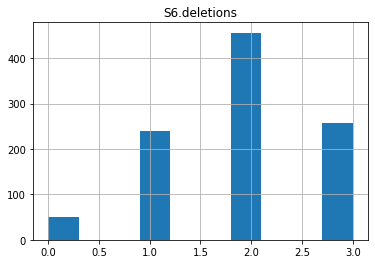

In [52]:
df_ins_freq.hist('S6.deletions')

### Figure ? - not currently in the paper
Reverse the data: how many mutations occer once, twice, three times etc.

In [199]:
def dna_mutation_frequencies(all_references):
    """
    Generate data for a histogram of DNA mutation frequencies - how many occur once, twice, ...
    :param all_references:
    :return:
    """
    freq = {}  # for each library ('d3', 'i6', etc.) give a dictionary {1: 5 times, 2: 3 times...}
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            freq['.'.join([background,fraction])] = defaultdict(int)
            for prot_mutation in all_references[background][fraction].keys():
                for dna_mutation, c in all_references[background][fraction][prot_mutation]['dna'].items():
                    dna_mut_type = classify_dna(dna_mutation)
                    prot_mut_type = classify_protein(prot_mutation)
                    if (dna_mut_type == fraction) and (prot_mut_type in dna_protein_correspondence(dna_mut_type)):
                        freq['.'.join([background,fraction])][c] += 1
    return freq

hist_Poisson = dna_mutation_frequencies(all_ref)
df_hist_Poisson = pd.DataFrame(hist_Poisson, columns=fractions).fillna(0).astype('int32')
df_hist_Poisson.head()

,S6.d3,S6.d6,S6.d9,S6.i3,S6.i6,S6.i9
1,30,30,30,5508,80377,92496
2,17,35,28,3351,17777,8381
3,23,23,16,2257,5013,1165
4,13,19,22,1749,1600,253
5,10,12,10,1272,569,89


index = number of times a mutation is observed
column = number of such mutations

This still needs manual clipping.

In [230]:
def plot_S7_Poisson(library, cutoff,title):
    hist_data = df_hist_Poisson[library].iloc[:cutoff + 1]
    main_max = hist_data.max()
    after_trunc = df_hist_Poisson[library].iloc[cutoff:].sum()

    hist_data.iloc[cutoff] = after_trunc # that has the data with the last entry in series being cumulative

    
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 4]}, figsize=(5,5))

    f.suptitle(title)
    
    bins = list(range(1, cutoff+1)) + [cutoff + 5]

    ax.bar(bins, hist_data) # first arguement is x-position, second is height
    ax2.bar(bins,hist_data)

    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(after_trunc - 2, after_trunc + 2)  # outliers only
    ax2.set_ylim(0, main_max + 1)  # most of the data
    
    ax2.set_ylabel('Count (X)')
    ax2.set_xlabel('Number of mutations in library observed X-times')

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # set the tick label for overflow bin
    xlabels_pos = [1,5,10,20,30,40,50,55]
    xlabels = [str(pos) for pos in xlabels_pos]
    xlabels[-1] = str(cutoff) + '+'
    ax2.xaxis.set_ticks(xlabels_pos)
    ax2.set_xticklabels(xlabels)
    # hide the axes labels on top
    ax.axes.get_xaxis().set_visible(False) 


    # This looks pretty good, and was fairly painless, but you can get that
    # cut-out diagonal lines look with just a bit more work. The important
    # thing to know here is that in axes coordinates, which are always
    # between 0-1, spine endpoints are at these locations (0,0), (0,1),
    # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
    # appropriate corners of each of our axes, and so long as we use the
    # right transform and disable clipping.

    d = .012  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-4*d, +4*d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-4*d, +4*d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    f.savefig('FigS7_' + library +'.png', format='png', dpi=600)
    plt.show()

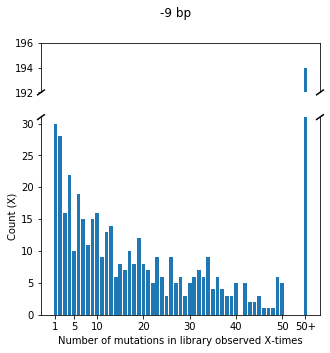

In [233]:
plot_S7_Poisson('S6.d9', 50, '-9 bp') 

The insertion libraries have a simpler distribution, no split axes needed.

In [220]:
def plot_S7_Poisson_ins(library, cutoff,title):
    hist_data = df_hist_Poisson[library].iloc[:cutoff + 1]
    main_max = hist_data.max()
    axes_split = hist_data[2]
    after_trunc = df_hist_Poisson[library].iloc[cutoff:].sum()

    hist_data.iloc[cutoff] = after_trunc # that has the data with the last entry in series being cumulative

    
    f, ax2 = plt.subplots(1, figsize=(5,5))

    f.suptitle(title)
    
    bins = list(range(1, cutoff+1)) + [cutoff + 3]

    ax2.bar(bins,hist_data, color='purple')
 
    ax2.set_ylabel('Count (X)')
    ax2.set_xlabel('Number of mutations in library observed X-times')


    # set the tick label for overflow bin
    xlabels_pos = [1,2,3,4,5,6,7,8,9,10,12]
    xlabels = [str(pos) for pos in xlabels_pos]
    xlabels[-1] = str(cutoff) + '+'
    ax2.xaxis.set_ticks(xlabels_pos)
    ax2.set_xticklabels(xlabels)

    f.savefig('FigS7_' + library +'.png', format='png', dpi=600)
    plt.show()





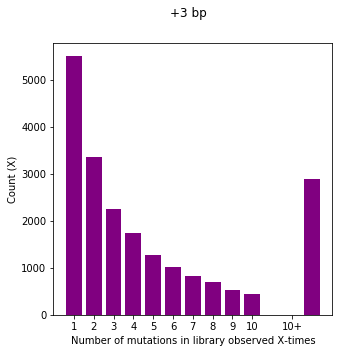

In [223]:
plot_S7_Poisson_ins('S6.i3', 10, '+3 bp') 

In [234]:
def insertion_composition(all_references, cutoff=2, l=(3,6,9)):

    comp = {length: {k: {'A':0, 'C':0, 'T':0, 'G':0} for k in range(length)} for length in l}
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            for mutation in all_references[background][fraction].keys():
                for dna_error, c in all_references[background][fraction][mutation]['dna'].items():
                    if dna_error is None:
                        continue
                    if c >= cutoff and len(dna_error) == 1 and classify_dna(dna_error) in ('i3', 'i6', 'i9'):
                        ins = dna_error[0][2]
                        ins_len = len(ins)
                        if ins_len in l:
                            for pos in range(ins_len):
                                comp[ins_len][pos][ins[pos]] += 1
    return comp


# # 4. Get position by position ACGT composition of insertions - SI Figure
ins_composition = insertion_composition(all_ref)
print('ACGT composition of insertions, for each position separately')
pprint.pprint(ins_composition)
print()
#

ACGT composition of insertions, for each position separately
{3: {0: {'A': 4586, 'C': 3076, 'G': 3827, 'T': 3840},
     1: {'A': 4359, 'C': 3328, 'G': 3434, 'T': 4208},
     2: {'A': 3531, 'C': 3643, 'G': 3094, 'T': 5061}},
 6: {0: {'A': 5057, 'C': 4941, 'G': 9202, 'T': 6622},
     1: {'A': 5046, 'C': 5273, 'G': 8572, 'T': 6931},
     2: {'A': 4982, 'C': 5071, 'G': 8194, 'T': 7575},
     3: {'A': 5427, 'C': 4955, 'G': 7761, 'T': 7679},
     4: {'A': 5596, 'C': 4631, 'G': 8005, 'T': 7590},
     5: {'A': 3627, 'C': 5589, 'G': 6323, 'T': 10283}},
 9: {0: {'A': 2122, 'C': 1903, 'G': 3591, 'T': 2443},
     1: {'A': 2070, 'C': 2193, 'G': 3208, 'T': 2588},
     2: {'A': 1992, 'C': 2139, 'G': 3128, 'T': 2800},
     3: {'A': 2153, 'C': 2145, 'G': 3007, 'T': 2754},
     4: {'A': 2042, 'C': 2208, 'G': 3092, 'T': 2717},
     5: {'A': 2089, 'C': 2032, 'G': 2948, 'T': 2990},
     6: {'A': 2156, 'C': 1844, 'G': 3019, 'T': 3040},
     7: {'A': 2228, 'C': 1776, 'G': 3087, 'T': 2968},
     8: {'A': 1496

In [ ]:
def rev_comp(nt):
    complement = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    return complement[nt]


def transposon_consensus_seq(all_references, reference, fraction='d3', transposon='d3', start_offset=3):
    """
    Determine the consensus sequence for transposon insertion, by analysing the position of d3 or i3 mutations
    :param all_references: dictionary containing all mutation data
    :param reference: BioSeq fasta reference
    :param fraction: name of the activity fraction / library to be analysed
    :param transposon: which type of mutations are we counting
    :return: dict with composition by position
    """
    consensus = {pos: {'A': 0, 'T': 0, 'C': 0, 'G': 0} for pos in range(5)}
    baseline = {pos: {'A': 0, 'T': 0, 'C': 0, 'G': 0} for pos in range(5)}
    ref = SeqIO.read(reference, 'fasta')

    for i in range(2, len(ref)-7):
        trans_seq = str(ref[i:i+5].seq)
        for pos in range(5):
            baseline[pos][trans_seq[pos]] += 1
            baseline[pos][rev_comp(trans_seq[4 - pos])] += 1

    background = str(ref.name)

    deletions = all_references[background][fraction]
    for prot_mutation in deletions.keys():
        for dna_mutation, count in deletions[prot_mutation]['dna'].items():
            if classify_dna(dna_mutation) == transposon:  # found the simple mutations: d3 or i3
                n1 = int(dna_mutation[0][0]) + start_offset - 2
                # this position refers to the nt in the first position of  the indel in 1-count:
                # hence this is the 2nd nt of 5 nt site -> need to retrieve start-1:start+4
                # Correct for offset: if start = 1: this is ref[start_offset]
                # Therefore N1 = start_offset + start -2
                if transposon == 'd3':
                    trans_seq = str(ref[n1:n1+5].seq)
                if len(trans_seq) != 5:
                    continue
                for pos in range(5):
                    consensus[pos][trans_seq[pos]] += count
                    consensus[pos][rev_comp(trans_seq[4 - pos])] += count

    return baseline, consensus

# 3. Find TransDel consensus sequence in -3 bp library - gives number of observations for the NNNNN target site
# This is used for WebLogo in Fig. 3A
d3_baseline, d3_cons = transposon_consensus_seq(all_ref, args.reference, fraction='d3', start_offset=args.start_offset)
print('TransDel consensus sequence: baseline counts (reflect GC composition)')
pprint.pprint(d3_baseline)
print('TransDel consensus counts')
pprint.pprint(d3_cons)
print()